# Sprint 5: Evaluación, Optimización y Despliegue

**Objetivo:** Este notebook cubre la fase final de entrenamiento y optimización del modelo. A diferencia de las fases anteriores, aquí nos enfocamos en refinar el modelo seleccionado (Boosting), optimizar su umbral de decisión para maximizar el F2-Score (dando prioridad a la sensibilidad/recall) y preparar los artefactos finales para el despliegue.

## Pasos a realizar:
1.  **Carga y Preparación de Datos:** Ingesta de datos procesados.
2.  **Configuración del Experimento (PyCaret):** Setup con manejo de desbalance.
3.  **Entrenamiento y Selección:** Comparación de modelos (foco en XGBoost/LGBM).
4.  **Optimización de Hiperparámetros:** Tuning del modelo para mejorar Recall.
5.  **Análisis de Umbral (Threshold):** Búsqueda del punto de corte óptimo.
6.  **Finalización y Persistencia:** Entrenamiento con todos los datos y guardado.
7.  **Simulación de Inferencia:** Prueba rápida del pipeline guardado.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle

# PyCaret
from pycaret.classification import setup, compare_models, tune_model, finalize_model, save_model, load_model, predict_model, pull, get_config
from sklearn.metrics import fbeta_score, recall_score, precision_score, confusion_matrix, classification_report

# Configuración de visualización
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

## 1. Carga de Datos
Cargamos el dataset procesado que generamos en el Sprint 4 (`processed_data.parquet`). Este dataset ya tiene las variables codificadas y limpias.

In [9]:
import pandas as pd
import os

# Ruta del archivo
data_path = "../data/02_intermediate/processed_data.parquet"

# 1. Cargar Datos
if os.path.exists(data_path):
    df = pd.read_parquet(data_path)
else:
    # Fallback
    data_path = "data/02_intermediate/processed_data.parquet"
    if os.path.exists(data_path):
        df = pd.read_parquet(data_path)
    else:
        raise FileNotFoundError("No se encuentra el archivo processed_data.parquet")

# --- PASO CRÍTICO 1: Eliminar el índice duplicado original ---
# Esto evita el MemoryError inmediatamente después de cargar
df = df.reset_index(drop=True)

# --- PASO 2: CONFIGURACIÓN DE MUESTREO (Tu idea) ---
# Cambia esto a False cuando estés listo para el "Gran Entrenamiento" final
MODO_PRUEBA_RAPIDA = True 
PORCENTAJE_MUESTRA = 0.03  # 5% de los datos

if MODO_PRUEBA_RAPIDA:
    print(f"⚠️ MODO PRUEBA ACTIVADO: Usando solo el {PORCENTAJE_MUESTRA*100}% de los datos.")
    print(f"   Filas originales: {len(df)}")
    
    # Tomamos el 5% aleatorio
    df = df.sample(frac=PORCENTAJE_MUESTRA, random_state=42)
    
    # --- PASO CRÍTICO 3: Re-ordenar índice de la muestra ---
    # Al muestrear, los índices quedan salteados (ej: 1, 10, 55...). 
    # PyCaret prefiere índices ordenados (0, 1, 2, 3...)
    df = df.reset_index(drop=True)
    
    print(f"   Filas para entrenamiento: {len(df)}")
else:
    print(f"✅ MODO PRODUCCIÓN: Usando EL 100% de los datos ({len(df)} filas).")
    # (El índice ya se reseteó en el Paso 1, así que estamos bien)

# -------------------------------------------------------

# Identificar target (Target)
target_col = 'CVDINFR4'
if target_col not in df.columns:
    if 'CVDCRHD4' in df.columns:
        target_col = 'CVDCRHD4'
    else:
        raise ValueError("No target found")

print(f"Target: {target_col}")
print(f"Data shape final: {df.shape}")

⚠️ MODO PRUEBA ACTIVADO: Usando solo el 3.0% de los datos.
   Filas originales: 442067
   Filas para entrenamiento: 13262
Target: CVDINFR4
Data shape final: (13262, 327)


## 2. Configuración del Experimento (Setup)
Iniciamos PyCaret. Usamos `fix_imbalance=True` para aplicar SMOTE automáticamente en el set de entrenamiento, ya que sabemos que la clase positiva (enfermedad cardíaca) es minoritaria.

In [10]:
exp = setup(
    data=df,
    target=target_col,
    session_id=42,
    fix_imbalance=True, # Importante para clases desbalanceadas
    verbose=False,
    html=True
)

print("Setup completado. Configuración:")
print(f"Train shape: {get_config('X_train').shape}")
print(f"Test shape: {get_config('X_test').shape}")

Setup completado. Configuración:
Train shape: (9283, 326)
Test shape: (3979, 326)


## 3. Comparación y Selección de Modelos
Comparamos varios modelos, pero nos enfocamos en los basados en árboles (Gradient Boosting) que suelen funcionar mejor para datos tabulares. Ordenamos por `Recall` porque nos interesa minimizar los Falsos Negativos.

In [13]:
# Limitamos a modelos rápidos y potentes para la demo
#best_model = compare_models(
#    include=['xgboost', 'lightgbm', 'rf', 'gbc'],
#    sort='Recall',
#    n_select=1
#)

best_model = compare_models(
    include=['xgboost', 'lightgbm'],  # <--- AQUÍ ESTÁ EL TRUCO (Quitamos 'rf' y 'gbc')
    sort='Recall',
    n_select=1
)

print(f"Mejor modelo seleccionado: {best_model}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9754,0.9928,0.7515,0.8012,0.7727,0.7598,0.7617,1.4680
xgboost,Extreme Gradient Boosting,0.9759,0.9928,0.7476,0.8105,0.7751,0.7624,0.7646,0.8540


Mejor modelo seleccionado: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


## 4. Optimización de Hiperparámetros (Tuning)
Buscamos mejorar el rendimiento del modelo seleccionado. Optimizamos explícitamente para `Recall`.

In [15]:
print("Optimizando hiperparámetros...")
tuned_model = tune_model(best_model, optimize='Recall', n_iter=1)

print("Modelo optimizado:")
print(tuned_model)

Optimizando hiperparámetros...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9817,0.9966,0.8269,0.8431,0.8350,0.8253,0.8253
1,0.9742,0.9943,0.7115,0.8043,0.7551,0.7415,0.7431
2,0.9774,0.9922,0.8462,0.7719,0.8073,0.7954,0.7963
3,0.9688,0.9910,0.7255,0.7115,0.7184,0.7019,0.7019
4,0.9709,0.9887,0.6731,0.7778,0.7216,0.7064,0.7084
5,0.9666,0.9889,0.7500,0.6842,0.7156,0.6979,0.6987
6,0.9752,0.9926,0.7115,0.8222,0.7629,0.7499,0.7521
7,0.9752,0.9915,0.7692,0.7843,0.7767,0.7636,0.7636
8,0.9828,0.9957,0.7885,0.8913,0.8367,0.8277,0.8294


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Modelo optimizado:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


## 5. Análisis de Umbral (Threshold Optimization)
El umbral por defecto es 0.5. Sin embargo, para maximizar el F2-Score (que valora el Recall sobre la Precision), necesitamos mover este umbral. Calculamos las métricas para distintos umbrales y elegimos el óptimo.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9739,0.9927,0.7130,0.7990,0.7536,0.7398,0.7411



🎯 Mejor Umbral (F2-Score): 0.01
F2-Score: 0.8562
Recall: 0.9238
Precision: 0.6624


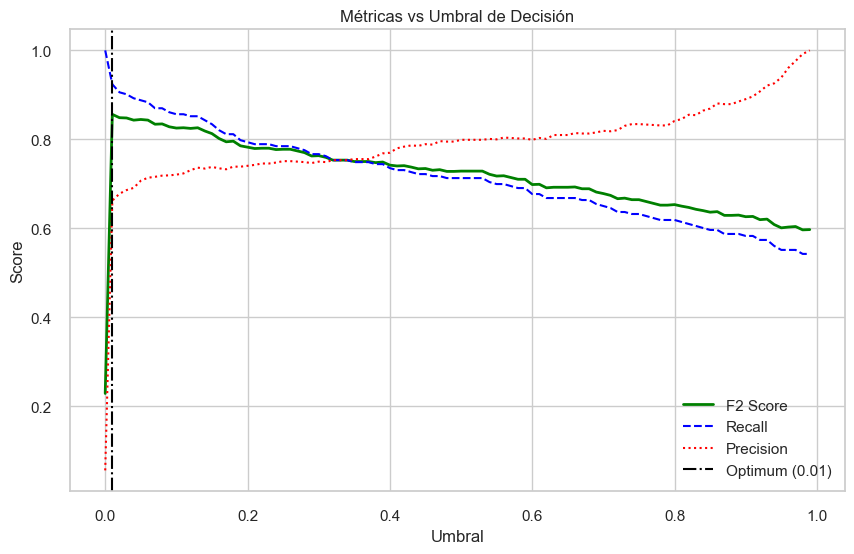

In [16]:
# Predecir probabilidades en el set de prueba (hold-out)
predictions = predict_model(tuned_model, raw_score=True)

# Extraer etiquetas reales y scores
y_true = predictions[target_col]

# PyCaret nombra las columnas de score como prediction_score_1 o Score_1
score_cols = [c for c in predictions.columns if 'score' in c.lower() or 'prob' in c.lower()]
# Buscamos la columna de la clase positiva (generalmente 1)
possible_score_cols = ['prediction_score_1', 'Score_1', 'proba_1']
score_col = next((c for c in possible_score_cols if c in predictions.columns), None)

if score_col:
    y_scores = predictions[score_col]
    
    thresholds = np.arange(0, 1, 0.01)
    f2_scores = []
    recalls = []
    precisions = []

    for t in thresholds:
        y_pred_t = (y_scores >= t).astype(int)
        f2_scores.append(fbeta_score(y_true, y_pred_t, beta=2))
        recalls.append(recall_score(y_true, y_pred_t))
        precisions.append(precision_score(y_true, y_pred_t, zero_division=0))

    # Encontrar el mejor umbral para F2
    best_idx = np.argmax(f2_scores)
    best_thresh = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]
    
    print(f"\n\U0001f3af Mejor Umbral (F2-Score): {best_thresh:.2f}")
    print(f"F2-Score: {best_f2:.4f}")
    print(f"Recall: {recalls[best_idx]:.4f}")
    print(f"Precision: {precisions[best_idx]:.4f}")
    
    # Visualización
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f2_scores, label='F2 Score', color='green', linewidth=2)
    plt.plot(thresholds, recalls, label='Recall', color='blue', linestyle='--')
    plt.plot(thresholds, precisions, label='Precision', color='red', linestyle=':')
    plt.axvline(best_thresh, color='black', linestyle='-.', label=f'Optimum ({best_thresh})')
    plt.title('Métricas vs Umbral de Decisión')
    plt.xlabel('Umbral')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

else:
    print("No se encontró columna de probabilidad. Se usará umbral por defecto 0.5")
    best_thresh = 0.5

In [17]:
# 1. Ver qué tan importantes son las variables (Detectar Leakage)
print("Top 10 Variables más importantes:")
try:
    # Para modelos de árboles (LGBM, XGB, RF)
    print(best_model.feature_importances_)
    # O mejor aún, usa la gráfica de PyCaret si funciona:
    # plot_model(best_model, plot='feature')
except:
    print("No se pudo sacar feature_importances directo.")

# 2. Ver la distribución real de tu Test Set
# (Asegúrate de tener la variable 'y_true' del bloque anterior)
try:
    dist = y_true.value_counts(normalize=True)
    print("\nDistribución real del Test Set:")
    print(dist)
    if dist.get(1, 0) > 0.4:
        print("🚨 ALERTA: Tu Test Set está BALANCEADO artificialmente (50/50). Eso infla los resultados.")
    else:
        print("✅ Test Set desbalanceado (Realista).")
except:
    pass

Top 10 Variables más importantes:
[ 36  18 212   3   0   5   3   0   3   5   9   2   8   9   3  63   2   6
  36   0   0   0   0   6   3   9   4   3   6   0   0   0   0  16   1   0
  31  15  11   5  25  41  20  32  11  21   0   2  20  33  29  23 103  13
  13   0  20   7   6   9   7  24  11  30  23  25   5  11   0  11   4  21
   0  25   6  45  33   2   3  18   9   3   4  25  17  15   7   1  10  23
   2  32  41   5   0   5   5   5   2   3   4   0   0   8   1   1   6  19
  16  12  10  12   3  24   9  15   2   6  23  12  42   5   6   0  10   3
   0   6   5   1   1   0   0   3   0   0   0   0   0   0   6   0   8   0
   9   3   0   0   0   0   0  13   4   9   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0  14   8   0   0   0   4  10   1   2   1  10
   0   0   1   5   0   1   0   0   3   6   1   1   0   1   1   5   0  18
  15  20   0   1  15   6   0   7  29  19   0   0   0   0   0   0   7   1
   0   0   0   3  12   6   4   1   0   0   0   0   0   0   0   0   3   5
   6   8   0   0 

In [22]:
# 1. Diagnóstico (Opcional, para ver la diferencia)
print(f"Nombres en Configuración: {len(feature_names)}")
print(f"Importancias en Modelo: {len(importances)}")

# 2. CORRECCIÓN: Obtener nombres directamente del modelo LightGBM/XGBoost
try:
    # Intentamos buscar el atributo donde el modelo guarda los nombres
    if hasattr(best_model, 'feature_name_'):
        real_names = best_model.feature_name_
    elif hasattr(best_model, 'feature_names_in_'):
        real_names = best_model.feature_names_in_
    else:
        # Si falla, cortamos/ajustamos la lista original al tamaño de las importancias
        print("⚠️ No se encontraron nombres internos. Ajustando longitud a la fuerza...")
        real_names = feature_names[:len(importances)]

    # 3. Crear el DataFrame con los nombres REALES
    feature_imp_df = pd.DataFrame({
        'Variable': real_names,
        'Importancia': importances
    }).sort_values(by='Importancia', ascending=False)

    print("\n🚨 TOP 10 VARIABLES SOSPECHOSAS DE LEAKAGE 🚨")
    display(feature_imp_df.head(10))

except Exception as e:
    print(f"❌ Error al extraer nombres: {e}")
    print("Intenta usar el gráfico automático de PyCaret:")
    from pycaret.classification import plot_model
    plot_model(best_model, plot='feature')

Nombres en Configuración: 326
Importancias en Modelo: 332

🚨 TOP 10 VARIABLES SOSPECHOSAS DE LEAKAGE 🚨


,Variable,Importancia
2,IDATE,212
52,CVDCRHD4,103
277,MICHD,100
15,IDAY,63
292,AGE80,57
297,BMI5,53
323,LCSREC,48
267,LLCPWT,47
75,WEIGHT2,45
120,TETANUS1,42


## 6. Finalización y Persistencia (Model Finalization)
Una vez satisfechos con los hiperparámetros y el umbral, entrenamos el modelo con **todos** los datos disponibles (Train + Test) para maximizar la información aprendida antes del despliegue.

In [20]:
print("Finalizando modelo (entrenando con dataset completo)...")
final_model = finalize_model(tuned_model)

# Guardar Artefactos
output_dir = "../models"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. Guardar Pipeline (.pkl)
model_name = "final_pipeline_v1"
save_path = os.path.join(output_dir, model_name)
save_model(final_model, save_path)

# 2. Guardar Configuración (Umbral)
config_data = {
    "threshold": float(best_thresh),
    "model_name": str(best_model.__class__.__name__),
    "metric_optimized": "F2-Score"
}

config_path = os.path.join(output_dir, "model_config.json")
with open(config_path, 'w') as f:
    json.dump(config_data, f, indent=4)

print(f"\n\u2705 Modelo guardado en: {save_path}.pkl")
print(f"\u2705 Configuración guardada en: {config_path}")



Finalizando modelo (entrenando con dataset completo)...
Transformation Pipeline and Model Successfully Saved

✅ Modelo guardado en: ../models\final_pipeline_v1.pkl
✅ Configuración guardada en: ../models\model_config.json


## 7. Simulación de Uso (Inferencia)
Demostramos cómo la aplicación (Streamlit) usaría estos archivos para hacer predicciones.

In [23]:
# Cargar pipeline
loaded_pipeline = load_model(save_path)

# Cargar config
with open(config_path, 'r') as f:
    loaded_config = json.load(f)
thresh = loaded_config['threshold']

print(f"Pipeline y umbral ({thresh}) cargados.")

# Tomar un ejemplo aleatorio del dataset original
sample_data = df.sample(1)
print("\nDatos de entrada (ejemplo):")
display(sample_data.drop(columns=[target_col]))

# Predecir Probabilidad
pred_raw = predict_model(loaded_pipeline, data=sample_data, raw_score=True)

# Lógica de decisión personalizada
score_col_final = [c for c in pred_raw.columns if 'score' in c.lower() and '1' in c][0]
prob = pred_raw[score_col_final].values[0]

decision = "ALTO RIESGO" if prob >= thresh else "BAJO RIESGO"

print(f"\nProbabilidad calculada: {prob:.4f}")
print(f"Umbral de corte: {thresh:.4f}")
print(f"Resultado Final: {decision}")

Transformation Pipeline and Model Successfully Loaded
Pipeline y umbral (0.01) cargados.

Datos de entrada (ejemplo):


,STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,PSU,CTELENM1,PVTRESD1,...,SMOKGRP,LCSREC,DRNKANY6,DROCDY4_,RFBING6,DRNKWK2,RFDRHV8,FLSHOT7,PNEUMO3,AIDTST4
9464,34.0,7.0,07252022,07,25,2022,1100.0,2.022002e+09,NaN,NaN,...,3.0,NaN,1.0,13.0,2.0,560.0,1.0,NaN,NaN,1.0


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,1.0000,0,0.0000,0.0000,0.0000,nan,0.0000



Probabilidad calculada: 0.0000
Umbral de corte: 0.0100
Resultado Final: BAJO RIESGO
